In [1]:
import warnings
warnings.filterwarnings("ignore")

import scanpy as sc
import cupy as cp

import time
import rapids_singlecell as rsc

import rmm
from rmm.allocators.cupy import rmm_cupy_allocator

rmm.reinitialize(
    managed_memory=False,  # Allows oversubscription
    pool_allocator=False,  # default is False
    devices=0,  # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)

In [2]:
adata = sc.read("../RData/4_chandraker_seurat_complete-dataset_clustered_res0-4_O2.h5ad")

In [3]:
rsc.get.anndata_to_GPU(adata)

In [4]:
adata

AnnData object with n_obs × n_vars = 29930 × 36601
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Log10GenesPerUMI', 'mitoRatio', 'riboRatio', 'barcode', 'patient_id', 'condition', 'TCR_clones', 'TCR_proportion', 'TCR_CDR3nt', 'TCR_CDR3aa', 'TCR_v_gene', 'TCR_d_gene', 'TCR_j_gene', 'TCR_chain', 'TCR_cellranger_clonotype_id', 'TCR_clonotype_id', 'BCR_clones', 'BCR_proportion', 'BCR_CDR3nt', 'BCR_CDR3aa', 'BCR_v_gene', 'BCR_d_gene', 'BCR_j_gene', 'BCR_chain', 'BCR_cellranger_clonotype_id', 'BCR_clonotype_id', 'repseq', 'predicted.celltype.l1.score', 'predicted.celltype.l1', 'predicted.celltype.l2.score', 'predicted.celltype.l2', 'predicted.celltype.l3.score', 'predicted.celltype.l3', 'mapping.score', 'SCT_snn_res.0.2', 'SCT_snn_res.0.3', 'SCT_snn_res.0.4', 'SCT_snn_res.0.6', 'SCT_snn_res.0.8', 'seurat_clusters', 'study_clusters', 'cluster_name'
    var: 'names'
    obsm: 'X_harmony', 'X_integrated_dr', 'X_pca', 'X_ref.umap', 'X_umap'
    layers: 'counts_RNA'

In [43]:
adata.fea

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3',
       'AL627309.2', 'AL627309.5', 'AL627309.4', 'AP006222.2', 'AL732372.1',
       ...
       'AC133551.1', 'AC136612.1', 'AC136616.1', 'AC136616.3', 'AC136616.2',
       'AC141272.1', 'AC023491.2', 'AC007325.1', 'AC007325.4', 'AC007325.2'],
      dtype='object', length=36601)

In [5]:
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator

rmm.reinitialize(
    managed_memory=False,  # Allows oversubscription
    pool_allocator=True,  # default is False
    devices=0,  # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)

In [6]:
%%time
rsc.pp.harmony_integrate(adata, key=["patient_id",
                                     "condition"],
                         dtype=cp.float32,)

CPU times: user 6.69 s, sys: 260 ms, total: 6.95 s
Wall time: 10.2 s


In [52]:
%%time
h_pca = "X_pca_harmony_sigma3"
rsc.pp.harmony_integrate(adata, key=["condition"],
                         dtype=cp.float32, adjusted_basis=h_pca,
                        theta=2)

CPU times: user 2.43 s, sys: 7.68 ms, total: 2.44 s
Wall time: 2.51 s


In [53]:
h_key = "harmony_sigma3"
h_umap = "X_umap_harmony_sigma3"
l_key = "leiden_harmony_sigma3"
rsc.pp.neighbors(adata, n_neighbors=15, n_pcs=40,
                 use_rep=h_pca, key_added=h_key)
rsc.tl.umap(adata,neighbors_key=h_key, 
            key_added=h_umap)

rsc.tl.leiden(adata, resolution=0.6, neighbors_key=h_key,
              key_added=l_key)

In [56]:
sc.pl.embedding(adata,basis=h_umap,
                color=["predicted.celltype.l1",
                       "condition", 
                      "repseq",
                       "patient_id",
                      l_key], ncols=1)

In [ ]:
rsc.pp.neighbors(adata, n_neighbors=15, n_pcs=40,
                 use_rep="X_pca_harmony", key_added="harmony")
rsc.tl.umap(adata,neighbors_key="harmony", 
            key_added="X_umap_harmony")

In [7]:
%%time
rsc.pp.neighbors(adata, n_neighbors=15, n_pcs=40,
                 use_rep="X_pca_harmony", key_added="harmony")
rsc.tl.umap(adata,neighbors_key="harmony", 
            key_added="X_umap_harmony")
rsc.tl.louvain(adata, resolution=0.6, 
               neighbors_key="harmony",key_added="louvain_harmony")
rsc.tl.leiden(adata, resolution=0.6, neighbors_key="harmony",
              key_added="leiden_harmony")

CPU times: user 1.11 s, sys: 371 ms, total: 1.48 s
Wall time: 2.5 s


In [8]:
%%time
sc.pl.embedding(adata,basis="X_umap_harmony", color=["louvain_harmony", "leiden_harmony"], legend_loc="on data")

CPU times: user 546 ms, sys: 19.6 ms, total: 565 ms
Wall time: 577 ms


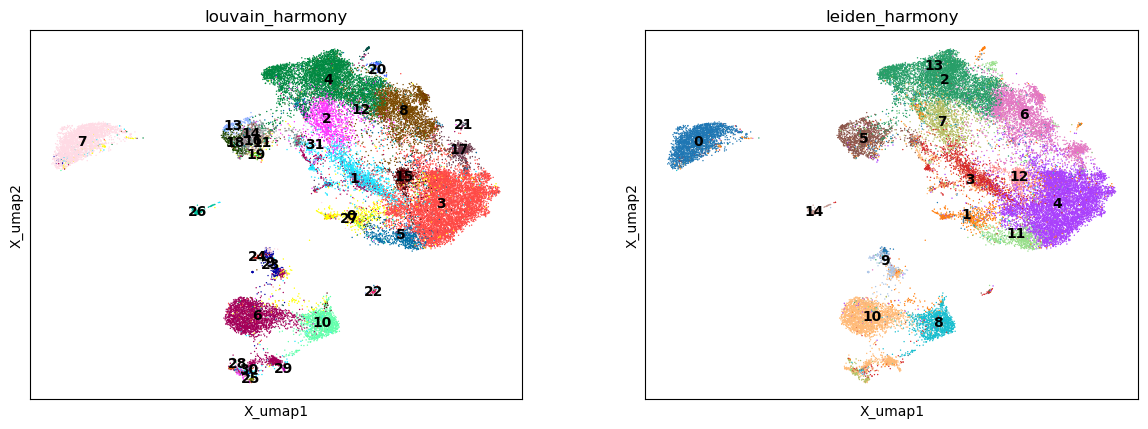

CPU times: user 398 ms, sys: 14.1 ms, total: 412 ms
Wall time: 412 ms


In [13]:
%%time
sc.pl.embedding(adata,basis="X_umap",
                color=["louvain_harmony", "leiden_harmony"], legend_loc="on data")

In [14]:
sc.pl.embedding(adata,basis="X_umap_harmony",
                color=["predicted.celltype.l1",
                       "condition"], ncols=1)

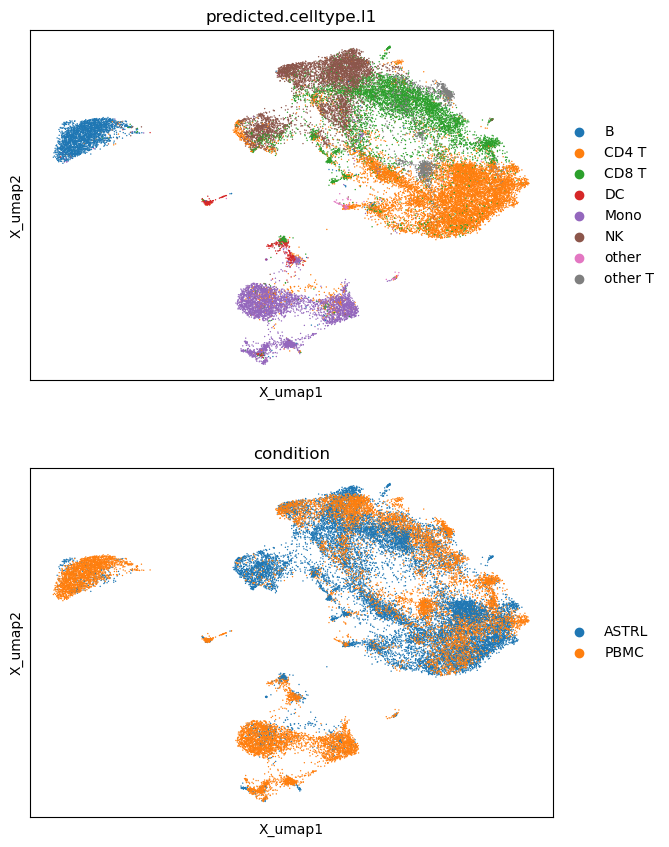

In [15]:
sc.pl.embedding(adata,basis="X_umap",
                color=["predicted.celltype.l1",
                       "condition"], ncols=1)

In [28]:
rsc.tl.tsne(adata, n_pcs=40, perplexity=20, early_exaggeration=12,
            learning_rate=200, use_rep="X_harmony")

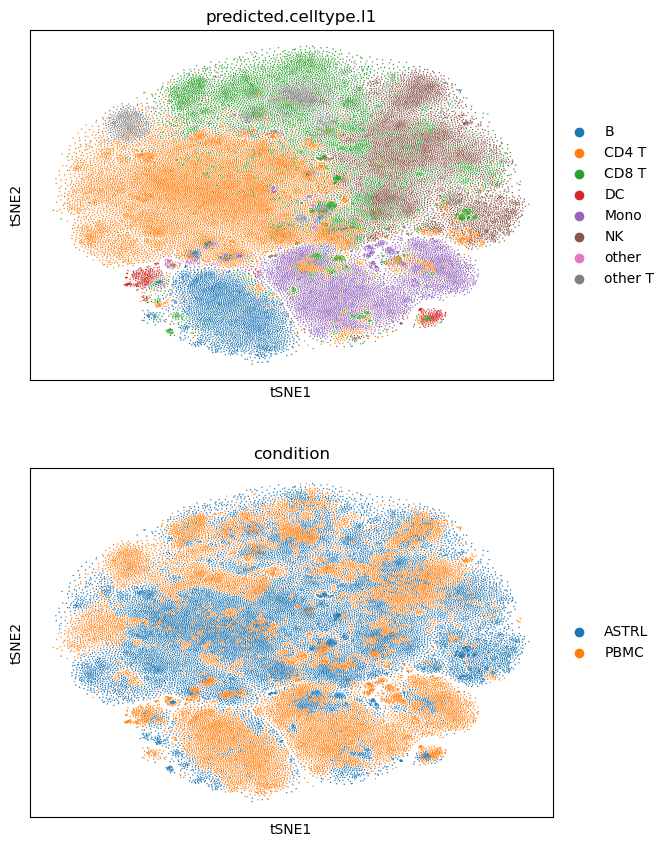

In [27]:
sc.pl.tsne(adata, color=["predicted.celltype.l1",
                       "condition"], ncols=1)

In [29]:
sc.pl.tsne(adata, color=["predicted.celltype.l1",
                       "condition"], ncols=1)